# Tests for the `cosmo` software package calculations/error model

Here, we test the accuracy of the calculations and error model implemented within the `cosmo` software suite (<a href=''>Marquez and Tissot, 2022</a>). 

## 1. Monte Carlo Simulations

### 1.1. Setup

Here, we use the 130-135 spike combination presecribed by the `cosmo.m` function (~85%-15% of $^{130}Ba$ and $^{135}Ba$ ORNL spikes), with a 50% splitting and 50% spike proportion. 

In [1]:
cd ..
dsstartup;
global ISODATA;

Welcome to the double spike toolbox.    John F. Rudge 2009-2022.
Default parameters are stored in the global variable ISODATA.
Type "global ISODATA" to access and set these parameters.


In [2]:
% INPUT parameters
element='Ba';
prop=0.5;
split=0.5;
spike=[0.319548 0.007732 0.030946 0.194053 0.049874 0.056732 0.341114];
cycles=40;

% fractionation factors
alpha=0.035; % equivalent to 1‰ in 138/134 Ba
beta=1.80;   % largest instrumental frac. from Table 3 Albarede et al. (2015)

Here, we run the `shake.m` function in order to (1) introduce the error model on the standard/unspiked measurement (by default, this is set at 0 for the original Double Spike Toolbox), and (2) modify the voltage of the sample in the error model.

For this test, we choose to have 40 cycles each for both IC (unspiked) and ID (spiked) measurement, wherein the sample corresponds to ~10V beam total. This means that the IC measurement shows 10 V per integraion, while the ID measurement shows 10/(1-prop) V/integration.

Below, we can calculate the equivalent sample amount (in ng) to reflect our intended measurement scenario:

$$ng\ sample = \frac{U\cdot t\cdot MM_{Ba}}{e\cdot R_{ref}\cdot Av.}$$

In [3]:
% constants
elementarycharge=1.60217646e-19;  % Coulombs
Avn=6.0221409e+14;   % Avogadro's number (nmol^-1)
MM=sum(ISODATA.(element).standard.*ISODATA.(element).mass); % molar mass of element

U=80000; % volts
deltat=8; % seconds
R_ref=1e11; % ohms

ng_sample=U*deltat*MM/(elementarycharge*R_ref*Avn)



ng_sample =

    9.1091



In this scenario, we are dealing with ~9 ng of Ba. This is relatively low compared to most applications (typically 30 ng in seawater, <a href="https://doi.org/10.1016/j.epsl.2015.07.027">Horner et al., 2015</a>) and is thus a good example for the typical applications where the splitting would be an important parameter to consider. 

Using these parameters, we run the shake.m functioon to setup our simulation:

In [5]:
R = [1e11 1e11 1e11 1e11 1e11 1e11 1e11;
     1e11 1e11 1e11 1e11 1e11 1e11 1e11];
     
effIC = 0.01; % ionization efficiency of the IC measurement
effID = 0.01; % ionization efficiency of the ID measurement
T     = 300; % temperature of the resistor/faraday cup; in Kelvin

shake(element,ng_sample,[effIC effID],[cycles cycles],R,R_ref,T,deltat)

Here, we adjust the error model for the measurement to reflect the fact that the sample represents 10V of each cycle of measurement.

In [6]:
ISODATA.(element).errormodel
ISODATA.(element).errormodel.measured
ISODATA.(element).errormodel.standard


ans = 

  struct with fields:

    measured: [1x1 struct]
       spike: [1x1 struct]
    standard: [1x1 struct]
        V100: 80000


ans = 

  struct with fields:

         type: 'fixed-sample'
    intensity: 10
            a: [1x7 double]
            b: [1x7 double]
            c: [0 0 0 0 0 0 0]
          eff: 0.0100
       cycles: 40


ans = 

  struct with fields:

         type: 'fixed-sample'
    intensity: 10
            a: [1x7 double]
            b: [1x7 double]
            c: [0 0 0 0 0 0 0]
          eff: 0.0100
       cycles: 40



We see here that indeed error model for Ba has been updated successfuly. 

### 1.2. Generating simulated beams using `monterun.m`

Here, we assume that beta varies with 2RSD = 10% throughout the run. 

In [7]:
RSD = 0.05;
beta_array = normrnd(beta,beta*RSD,1,cycles); % different betas value per cycle

Generating the simulated measurements with the `monterun.m` included in the original Double Spike Toolbox.

In [8]:
[measuredv,standardv]=monterun(element,prop,spike,alpha,beta,cycles);

Checking that the total beam voltages per cycle is correct

In [9]:
mean(sum(measuredv,2))


ans =

   20.0000



In [10]:
mean(sum(standardv,2))


ans =

   10.0000



### 1.3. Processing the Monte Carlo simulation data

#### 1.3.1. Spiked Data

In [11]:
alphaID=[]; %alpha values calculated per cycle
betaID=[]; %beta values calculated per cycle

isoinv=[130 134 135 138];

for i=1:length(measuredv)
    out=dsinversion(element,measuredv(i,:),spike,isoinv);
    
    alphaID(i)=out.alpha;
    betaID(i)=out.beta;
end

Checking that indeed we get the average values expected ($\mu_{\alpha} = 0.035$ and $\mu_{\beta} = 1.80$ as set in **Section 1.1**).

Next, we calculate 1SE for $\alpha$ from these monte carlo runs:

In [12]:
alpha1SD = std(alphaID)/sqrt(cycles)


alpha1SD =

   5.9214e-04



Just to check, the uncertainty estimated for the spiked measurement when the covariance matrix for the standard, $V_m = 0$ (*i.e.*, no uncertainty on the standard composition) should be similar.

In [13]:
ISODATA.(element).errormodel.standard.a=zeros(1,7);
ISODATA.(element).errormodel.standard.b=zeros(1,7);
errorwsplit('Ba',0.5,0.5,spike,isoinv)

%returning the standard error model
shake(element,ng_sample,[0.01 0.01],[cycles cycles],R,R_ref,300,deltat)


ans =

   7.0949e-04



In [14]:
alphaID2=[]; %alpha values calculated per cycle
betaID2=[]; %beta values calculated per cycle

isoinv=[130 134 135 138];

for i=1:length(measuredv)
    out=dsinversion(element,measuredv(i,:),spike,isoinv,standardv(i,:));
    
    alphaID2(i)=out.alpha;
    betaID2(i)=out.beta;
end

In [15]:
alpha1SD2 = std(alphaID2)/sqrt(cycles)


alpha1SD2 =

   8.4321e-04



In order to propagate the uncertainty from the standard into the final uncertainty on $\alpha$, here we convert $\sigma_{\alpha}$ into the RSD of a ratio, which here we choose to be $^{137}Ba/^{135}Ba$. From Eq. 6 in Appendix A of Rudge et al. (2009):

$$n_i=N_i\cdot e^{\alpha P_i}$$ 

The RSD for the ratio n_i would then be:

$$RSD_{n_i}=P_i\cdot \sigma_{\alpha}$$

In [17]:
ratisos = [137 135];
ratisos = ISODATA.(element).isoindex(ratisos);

P=log(ISODATA.(element).mass/ISODATA.(element).mass(ratisos(2)));

RSD_75=P(ratisos(1))*alpha1SD


RSD_75 =

   8.7148e-06



This will then be combined later with the RSD of the same ratio from the standard/unspiked measurement in order to achieve the final uncertainty on $\alpha$.

#### 1.3.2. Unspiked Data

Here, we process the simulated unspiked measurement (`standardv`). Here, we choose one particular ratio for the internal normalization (`INisos` - [j k]), from which we calculate the $\zeta$ using the following equation (Eq. 7 in <a href=https://doi.org/10.1039/C7JA00187H>Hu and Dauphas</a>: 

$$\zeta = \ln\left(\frac{r_{smp}^{j/k}}{R_{ref}^{j/k}}\right)\bigg/\ln\left(\frac{m_j}{m_k}\right)$$

In [18]:
% Specifying internal normalization ratio and calculating this ratio per cycle
INisos=[138 135];
INisos=ISODATA.Ba.isoindex(INisos);

% Calculating all ratios - using the same denominator as in ratisos
R=standardv./standardv(:,INisos(2));

% Calculating ratios used for internal normalization
R_samp=standardv(:,INisos(1))./standardv(:,INisos(2));

INrat_ref=ISODATA.(element).standard(INisos(1))/ISODATA.(element).standard(INisos(2)); %reference ratio
massrat_ref=P(1,INisos(1)); %ln(m_j/m_k)

% Calculating zeta
zeta=(log(R_samp./INrat_ref))/massrat_ref;
zeta=repmat(zeta,1,ISODATA.(element).nisos);

% Matrix of P_i vals
P_mat=repmat(P,length(R),1);

% Calculating internally normalized ratios
RIN=R.*exp(-P_mat.*zeta); 

We can now calculate the 1SE on the $^{137}Ba/^{135}Ba$ ratio for the unspiked measurement:

In [19]:
Ba_75_1SD=std(RIN(:,ratisos(1)))/sqrt(cycles); %1SD
RSD_75Std=Ba_75_1SD/mean(RIN(:,ratisos(1)))


RSD_75Std =

   7.4957e-06



#### 1.3. Combining Uncertainties

The $\delta^{\prime}_{137/135}$ value is defined as:

$$\delta^{\prime}_{137/135} = \ln\left(\frac{r_{smp}^{137/135}}{R_{std}^{137/135}}\right)\times 1000$$

From Eq. 48 in Rudge et al. (2009), we know that:

$$\delta^{\prime}_{137/135} = \alpha P_i\times 1000$$

We can then re-write:
$$\alpha = \frac{1}{P_i}\ln\left(\frac{r_{smp}^{137/135}}{R_{std}^{137/135}}\right)$$

As such, the uncertainty on $\alpha$ if both $r_{smp}$ and $R_{std}$ have errors can be written as:
$$\sigma_{\alpha} = \frac{1}{P_i}\sqrt{RSD_{r_{smp}}^2+RSD_{R_{std}}^2}$$

In [20]:
1/log(137/135)*hypot(RSD_75,RSD_75Std)


ans =

   7.8164e-04



We can then check if this is close the error estimate that we get from `errorwsplit.m` assuming the same sample amount and measurement parameters:

In [21]:
errorwsplit('Ba',0.5,0.5,spike,isoinv,INisos)


ans =

   8.6550e-04



Note the similarities in the estimated uncertainties. Next, we examine if changing the internal normalization scheme for processing the data leads to a similar increase in uncertainty as predicted by `errorwsplit.m`. 

### 1.4. Effect of normalization

Here, we test what happens when we choose a different normalization for the same data set. Here, we normalize to the $^{134}Ba/^{135}Ba$ ratio.

In [22]:
% Specifying internal normalization ratio and calculating this ratio per cycle
INisos=[134 135];
INisos=ISODATA.Ba.isoindex(INisos);

% Calculating all ratios - using the same denominator as in ratisos
R=standardv./standardv(:,INisos(2));

% Calculating ratios used for internal normalization
R_samp=standardv(:,INisos(1))./standardv(:,INisos(2));

INrat_ref=ISODATA.(element).standard(INisos(1))/ISODATA.(element).standard(INisos(2)); %reference ratio
massrat_ref=P(1,INisos(1)); %ln(m_j/m_k)

% Calculating zeta
zeta=(log(R_samp./INrat_ref))/massrat_ref;
zeta=repmat(zeta,1,ISODATA.(element).nisos);

% Matrix of P_i vals
P_mat=repmat(P,length(R),1);

% Calculating internally normalized ratios
RIN=R.*exp(-P_mat.*zeta); 

In [23]:
Ba_75_1SD=std(RIN(:,ratisos(1)))/sqrt(cycles); %1SD
RSD_75Std=Ba_75_1SD/mean(RIN(:,ratisos(1)))


RSD_75Std =

   3.7078e-05



Notice that the RSD on the $^{137}Ba/^{135}Ba$ ratio is almost an order of magnitude higher - this makes sense, given that we are using a less abundant isotope in $^{134}Ba$ for normalization, which would have a larger uncertainty from shot noise. 

Re-preforming the propagation on $\sigma_{\alpha}$:

In [24]:
1/log(137/135)*hypot(RSD_75,RSD_75Std)


ans =

    0.0026



In [25]:
errorwsplit('Ba',0.5,0.5,spike,isoinv,INisos)


ans =

    0.0026



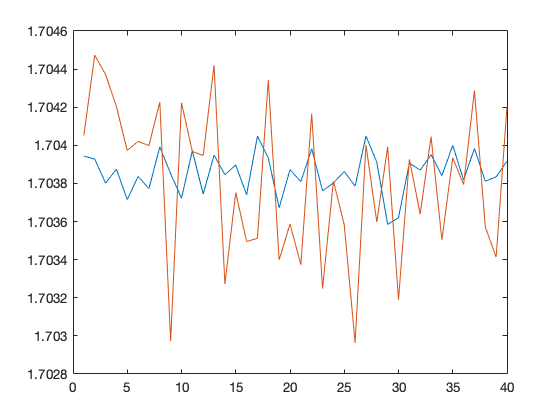

In [26]:
plot(1:length(R),R(:,ratisos(1)))
hold on
plot(1:length(RIN),RIN(:,ratisos(1)))